In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
TRAIN_DIR = "dataset/train"
TEST_DIR  = "dataset/test"

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
EPOCHS_HEAD = 10
EPOCHS_FINE = 6

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy(),
      "Val batches:", tf.data.experimental.cardinality(val_ds).numpy(),
      "Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

Found 305 files belonging to 3 classes.
Using 244 files for training.
Found 305 files belonging to 3 classes.
Using 61 files for validation.
Found 147 files belonging to 3 classes.
Classes: ['Baroque paintings', 'Medieval art', 'Renaissance paintings']
Train batches: 8 Val batches: 2 Test batches: 5


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.08),
], name="data_augmentation")

In [8]:
def apply_preprocess(images, labels):
    images = preprocess_input(images)
    return images, labels

def augment_and_preprocess(images, labels):
    images = data_augmentation(images)
    images = preprocess_input(images)
    return images, labels

train_ds = train_ds.map(augment_and_preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(apply_preprocess, num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(apply_preprocess, num_parallel_calls=AUTOTUNE)

In [10]:
base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False

model = tf.keras.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_cb = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

callbacks = [early_cb]

In [12]:
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks
)

Epoch 1/10
8/8 [==============================] - 12s 1s/step - loss: 1.0662 - accuracy: 0.4631 - val_loss: 0.9397 - val_accuracy: 0.5902
Epoch 2/10
8/8 [==============================] - 7s 890ms/step - loss: 0.8757 - accuracy: 0.5779 - val_loss: 0.8446 - val_accuracy: 0.6230
Epoch 3/10
8/8 [==============================] - 7s 890ms/step - loss: 0.7584 - accuracy: 0.6557 - val_loss: 0.7756 - val_accuracy: 0.6557
Epoch 4/10
8/8 [==============================] - 7s 842ms/step - loss: 0.6957 - accuracy: 0.7213 - val_loss: 0.7305 - val_accuracy: 0.6885
Epoch 5/10
8/8 [==============================] - 7s 892ms/step - loss: 0.6643 - accuracy: 0.7295 - val_loss: 0.7021 - val_accuracy: 0.6885
Epoch 6/10
8/8 [==============================] - 7s 879ms/step - loss: 0.6084 - accuracy: 0.7541 - val_loss: 0.6798 - val_accuracy: 0.7049
Epoch 7/10
8/8 [==============================] - 7s 910ms/step - loss: 0.5761 - accuracy: 0.7664 - val_loss: 0.6612 - val_accuracy: 0.7213
Epoch 8/10
8/8 [======

In [13]:
UNFREEZE_AT = -30

for layer in base.layers[:UNFREEZE_AT]:
    layer.trainable = False
for layer in base.layers[UNFREEZE_AT:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINE,
    callbacks=callbacks
)

Epoch 1/6
8/8 [==============================] - 13s 1s/step - loss: 0.6303 - accuracy: 0.7951 - val_loss: 0.6293 - val_accuracy: 0.7213
Epoch 2/6
8/8 [==============================] - 7s 840ms/step - loss: 0.6560 - accuracy: 0.7500 - val_loss: 0.6307 - val_accuracy: 0.7213
Epoch 3/6
8/8 [==============================] - 7s 837ms/step - loss: 0.6320 - accuracy: 0.7746 - val_loss: 0.6330 - val_accuracy: 0.7213
Epoch 4/6
8/8 [==============================] - 7s 845ms/step - loss: 0.6628 - accuracy: 0.7213 - val_loss: 0.6361 - val_accuracy: 0.7049
Epoch 5/6
8/8 [==============================] - 7s 836ms/step - loss: 0.6307 - accuracy: 0.7582 - val_loss: 0.6392 - val_accuracy: 0.7213
Epoch 6/6
8/8 [==============================] - 7s 845ms/step - loss: 0.6795 - accuracy: 0.7623 - val_loss: 0.6429 - val_accuracy: 0.7213


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [15]:
with open("class_names.json", "w") as f:
    json.dump(class_names, f)
print("Saved class_names.json")

Saved class_names.json


In [16]:
tf.saved_model.save(model, "painting_era_model")
print("Saved!")

INFO:tensorflow:Assets written to: painting_era_model\assets


INFO:tensorflow:Assets written to: painting_era_model\assets


Saved!


In [17]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}   Test accuracy: {test_acc:.4f}")

5/5 [==============================] - 6s 726ms/step - loss: 0.5912 - accuracy: 0.7415
Test loss: 0.5912   Test accuracy: 0.7415


In [18]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

pred_probs = model.predict(test_ds)
y_pred = np.argmax(pred_probs, axis=1)

5/5 [==============================] - 4s 639ms/step


In [19]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                       precision    recall  f1-score   support

    Baroque paintings       0.83      0.74      0.78        58
         Medieval art       0.89      0.79      0.84        52
Renaissance paintings       0.51      0.68      0.58        37

             accuracy                           0.74       147
            macro avg       0.74      0.74      0.73       147
         weighted avg       0.77      0.74      0.75       147



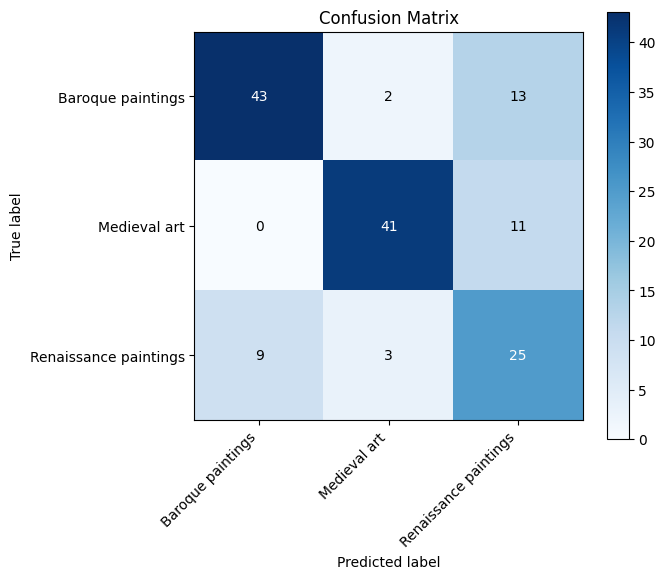

In [20]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

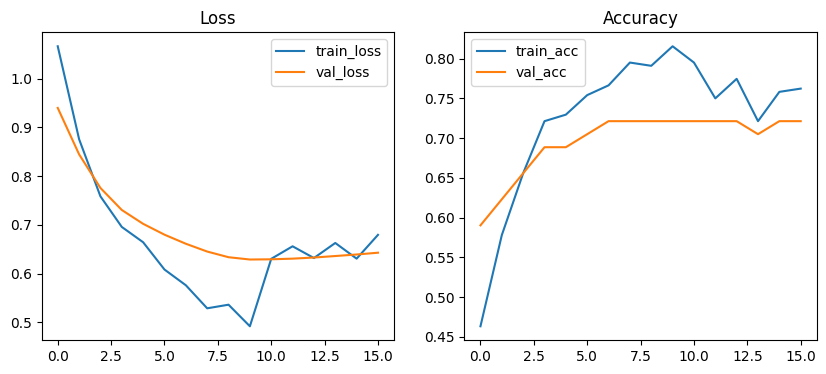

In [21]:
def get_history_dict(h1, h2=None):
    if h2 is None:
        return h1.history
    out = {}
    for k in h1.history.keys():
        out[k] = h1.history[k] + (h2.history.get(k, []))
    return out

hist = get_history_dict(history_head, history_fine if 'history_fine' in globals() else None)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(hist['accuracy'], label='train_acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Accuracy")
plt.show()